In [ ]:
import pandas as pd
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

file_path = 'train.csv'
data = pd.read_csv(file_path)


In [2]:

# Displaying missing values
missing_values = data.isnull().sum()
missing_values

id                                                0
scrape_id                                         0
last_scraped                                      0
name                                              0
description                                     225
picture_url                                       0
host_id                                           0
host_name                                         0
host_since                                        0
host_is_superhost                               428
host_listings_count                               0
host_total_listings_count                         0
host_verifications                                0
host_has_profile_pic                              0
host_identity_verified                            0
neighbourhood_cleansed                            0
neighbourhood_group_cleansed                      0
latitude                                          0
longitude                                         0
property_typ

In [3]:
descriptive_stats = data.describe()
descriptive_stats

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,beds,price,...,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
count,15441.000000,1.544100e+04,1.544100e+04,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15322.000000,15441.000000,...,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000
mean,7720.000000,2.023090e+13,1.814302e+08,117.346286,174.791270,34.049962,-118.340461,5.079399,2.759627,1.961337,...,34.704099,55.518425,203.750988,30.985169,8.514086,0.817564,24.701638,22.946571,1.644194,0.086393
std,4457.577089,0.000000e+00,1.756812e+08,597.470382,813.486601,0.140982,0.169908,3.223242,1.933759,1.619984,...,23.392779,34.384775,134.904394,67.792226,15.477778,1.522905,89.448423,89.248426,7.342761,1.475507
min,0.000000,2.023090e+13,7.670000e+02,0.000000,0.000000,33.338600,-118.916410,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3860.000000,2.023090e+13,2.372231e+07,1.000000,2.000000,33.997742,-118.438268,2.000000,1.000000,0.000000,...,9.000000,25.000000,82.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,7720.000000,2.023090e+13,1.084975e+08,3.000000,5.000000,34.061950,-118.361900,4.000000,2.000000,2.000000,...,41.000000,67.000000,215.000000,5.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000
75%,11580.000000,2.023090e+13,3.444546e+08,14.000000,23.000000,34.108080,-118.259989,7.000000,4.000000,3.000000,...,58.000000,88.000000,343.000000,29.000000,10.000000,1.000000,11.000000,8.000000,0.000000,0.000000
max,15440.000000,2.023090e+13,5.349146e+08,4576.000000,9168.000000,34.797857,-117.653360,16.000000,50.000000,5.000000,...,60.000000,90.000000,365.000000,1118.000000,183.000000,16.000000,692.000000,692.000000,78.000000,44.000000


<Figure size 2000x1800 with 0 Axes>

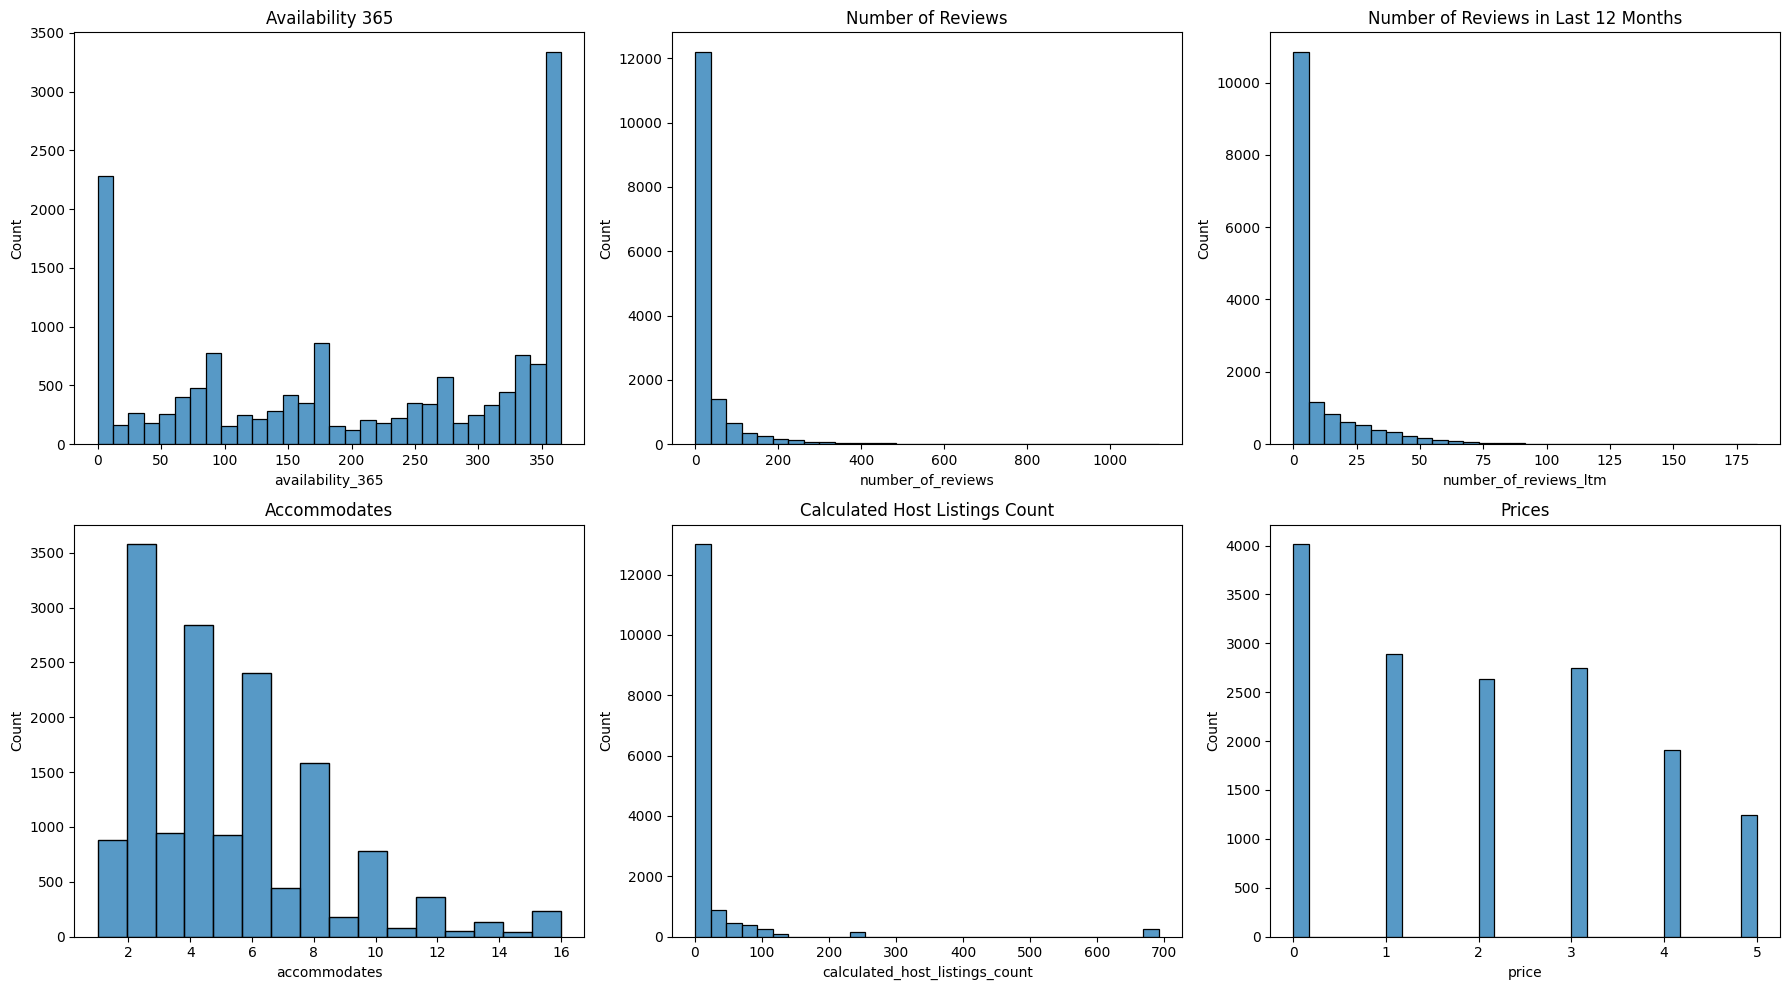

In [4]:


plt.figure(figsize=(20, 18))
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Availability 365 days
sns.histplot(data['availability_365'], bins=30, kde=False, ax=ax[0, 0])
ax[0, 0].set_title('Availability 365')

# Number of reviews
sns.histplot(data['number_of_reviews'], bins=30, kde=False, ax=ax[0, 1])
ax[0, 1].set_title('Number of Reviews')

# Number of reviews in the last 12 months
sns.histplot(data['number_of_reviews_ltm'], bins=30, kde=False, ax=ax[0, 2])
ax[0, 2].set_title('Number of Reviews in Last 12 Months')

# Accommodates
sns.histplot(data['accommodates'], bins=16, kde=False, ax=ax[1, 0])
ax[1, 0].set_title('Accommodates')

# Calculated host listings count
sns.histplot(data['calculated_host_listings_count'], bins=30, kde=False, ax=ax[1, 1])
ax[1, 1].set_title('Calculated Host Listings Count')

# Calculated price
sns.histplot(data['price'], bins=30, kde=False, ax=ax[1, 2])
ax[1, 2].set_title('Prices')

plt.tight_layout()
plt.show()

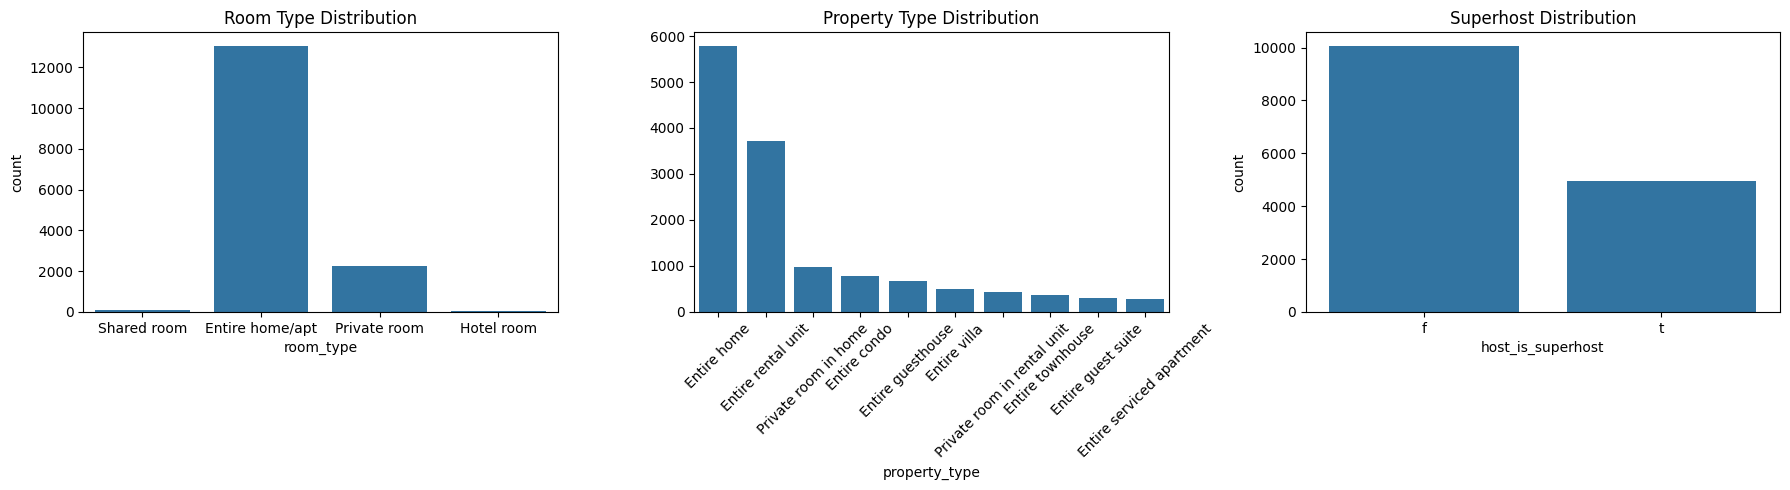

In [5]:
plt.figure(figsize=(18, 5))

#room_type
plt.subplot(1, 3, 1)
sns.countplot(data=data, x='room_type')
plt.title('Room Type Distribution')

#property_type 
plt.subplot(1, 3, 2)
property_type_counts = data['property_type'].value_counts().head(10)
sns.barplot(x=property_type_counts.index, y=property_type_counts.values)
plt.title('Property Type Distribution')
plt.xticks(rotation=45)

#host_is_superhost 
plt.subplot(1, 3, 3)
sns.countplot(data=data, x='host_is_superhost')
plt.title('Superhost Distribution')

plt.tight_layout()
plt.show()

In [6]:
def clean_and_split_amenities(amenities):
    amenities = amenities.strip('{}').replace('"', '').split(',')
    return [amenity.strip() for amenity in amenities if amenity]

def extract_bathroom_number(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    numbers = re.findall(r"[\d\.]+", text)
    return float(numbers[0]) if numbers else 0

def is_shared(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return 1 if 'shared' in text.lower() else 0

def is_private(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    return 1 if 'private' in text.lower() else 0




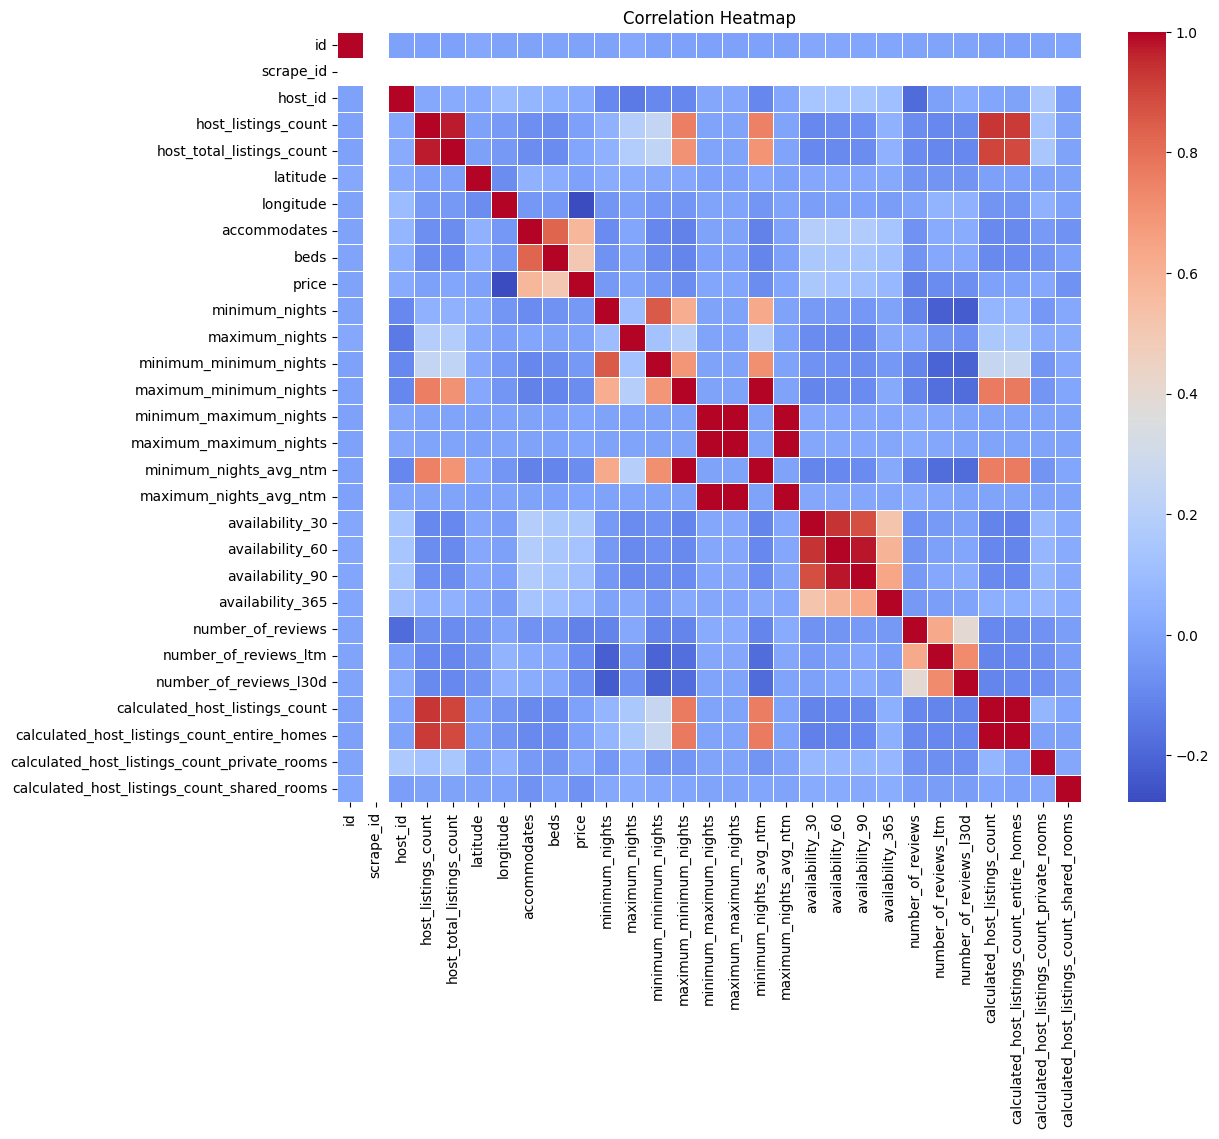

In [7]:

numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = data[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [32]:

property_type_freq = data['property_type'].value_counts(normalize=True)
neighbourhood_freq = data['neighbourhood_cleansed'].value_counts(normalize=True)

def process(data,neighbourhood_freq,property_type_freq):
    
    # Dropping unrelated variables
    unrelated_columns = ['id', 'scrape_id', 'host_id', 'host_name', 'name', 
                         'picture_url','host_verifications','last_scraped',
                         'calendar_last_scraped','description']
    data = data.drop(columns=unrelated_columns)

    # Converting to binary
    data['host_is_superhost'] = data['host_is_superhost'].map({'t': 1, 'f': 0})
    data['host_has_profile_pic'] = data['host_has_profile_pic'].map({'t': 1, 'f': 0})
    data['host_identity_verified'] = data['host_identity_verified'].map({'t': 1, 'f': 0})
    data['instant_bookable'] = data['instant_bookable'].map({'t': 1, 'f': 0})
    data['has_availability'] = data['has_availability'].map({'t': 1, 'f': 0})

    # Convert date features to numerical by calculating the number of days from today
    date_columns = ['host_since']
    current_date = pd.to_datetime('today')
    for col in date_columns:
        data[col] = pd.to_datetime(data[col])
        data[col] = (current_date - data[col]).dt.days

    data['bathroom_number'] = data['bathrooms_text'].apply(extract_bathroom_number)
    data['bathroom_shared'] = data['bathrooms_text'].apply(is_shared)
    data['bathroom_private'] = data['bathrooms_text'].apply(is_private)
    data.drop('bathrooms_text', axis=1, inplace=True)

    # Encoding with one-hot encoding
    room_type_dummies = pd.get_dummies(data['room_type'], prefix='room_type', drop_first=True,dtype=int)
    data = pd.concat([data, room_type_dummies], axis=1)
    data.drop('room_type', axis=1, inplace=True)
    neighbourhood_group_dummies = pd.get_dummies(data['neighbourhood_group_cleansed'], prefix='neighbourhood_group', drop_first=True,dtype=int)
    data = pd.concat([data, neighbourhood_group_dummies], axis=1)
    data.drop('neighbourhood_group_cleansed', axis=1, inplace=True)

    # Count amenities
    data['amenities_count'] = data['amenities'].str.count(',') + 1

    neighbor_freq = []
    for i in data['neighbourhood_cleansed']:
        if i in neighbourhood_freq:
            neighbor_freq.append(neighbourhood_freq[i])
        else:
            neighbor_freq.append(0)
    data['neighbourhood_freq'] = neighbor_freq
    data.drop('neighbourhood_cleansed', axis=1, inplace=True)
    
    property_freq = []
    for i in data['property_type']:
        if i in property_type_freq:
            property_freq.append(property_type_freq[i])
        else:
            property_freq.append(0)
    data['property_freq'] = property_freq
    data.drop(['property_type'], axis=1, inplace=True)

    print(len(data['property_freq']),len(data['neighbourhood_freq']))

    # Dropping the original 'amenities' column as it's no longer needed
    data.drop('amenities', axis=1, inplace=True)
    data = data.dropna()
    return data


cleaned_data=process(data,neighbourhood_freq,property_type_freq)
cleaned_data.to_csv('out.csv')


15441 15441


In [33]:
display(cleaned_data)

,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,beds,...,bathroom_shared,bathroom_private,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_group_Other Cities,neighbourhood_group_Unincorporated Areas,amenities_count,neighbourhood_freq,property_freq
0,1957,0.0,5.0,7.0,1,1,33.827490,-118.307950,3,1.0,...,1,0,0,0,1,0,0,35,0.000971,0.002914
1,3791,1.0,3.0,3.0,1,1,33.984040,-118.470020,6,2.0,...,0,0,0,0,0,0,0,60,0.049155,0.241111
2,1625,0.0,118.0,189.0,1,1,33.341870,-118.328470,8,4.0,...,0,0,0,0,0,1,0,28,0.008937,0.375040
3,764,0.0,5.0,6.0,1,1,34.450160,-118.553820,7,5.0,...,0,0,0,0,0,1,0,13,0.006282,0.375040
4,288,0.0,1020.0,1414.0,1,1,34.060360,-118.441710,2,1.0,...,0,0,0,1,0,0,0,23,0.011010,0.014377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15435,742,1.0,2.0,2.0,1,1,34.019230,-118.489680,2,1.0,...,0,0,0,0,0,1,0,53,0.037109,0.050256
15436,1181,0.0,23.0,30.0,1,1,34.146550,-118.254070,4,2.0,...,0,0,0,0,0,1,0,20,0.018457,0.241111
15438,2979,1.0,3.0,5.0,1,0,34.190990,-118.458840,2,1.0,...,0,0,0,0,0,0,0,52,0.003821,0.241111
15439,1707,0.0,54.0,61.0,1,1,33.946028,-118.342446,2,1.0,...,0,0,0,1,0,1,0,24,0.009391,0.007772


In [34]:

def split(data):
    # Separating the features and target variable
    X = data.drop('price', axis=1)  
    y = data['price']              
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split(cleaned_data)
print(len(X_train.columns))

42


In [35]:
def plot_search_results(results, hyperparameter, metric='mean_test_score'):
    results_df = pd.DataFrame(results)
    hyper_values = results_df['param_' + hyperparameter]
    metric_scores = results_df[metric]
    plt.figure(figsize=(10, 6))
    plt.scatter(hyper_values, metric_scores)
    plt.xlabel(hyperparameter)
    plt.ylabel(metric)
    plt.legend()
    plt.show()


In [36]:

# hyperparameters for Bayesian Optimization
RF_param = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': ['log2', 'sqrt'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Using Bayesian Optimization for hyperparameter tuning
bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=RF_param,
    n_iter=32,
    scoring=make_scorer(f1_score,average='weighted'),
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    random_state=42
)

# Fitting the model
bayes_search.fit(X_train, y_train)
bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 23),
             ('max_features', 'log2'),
             ('min_samples_leaf', 1),
             ('min_samples_split', 6),
             ('n_estimators', 967)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


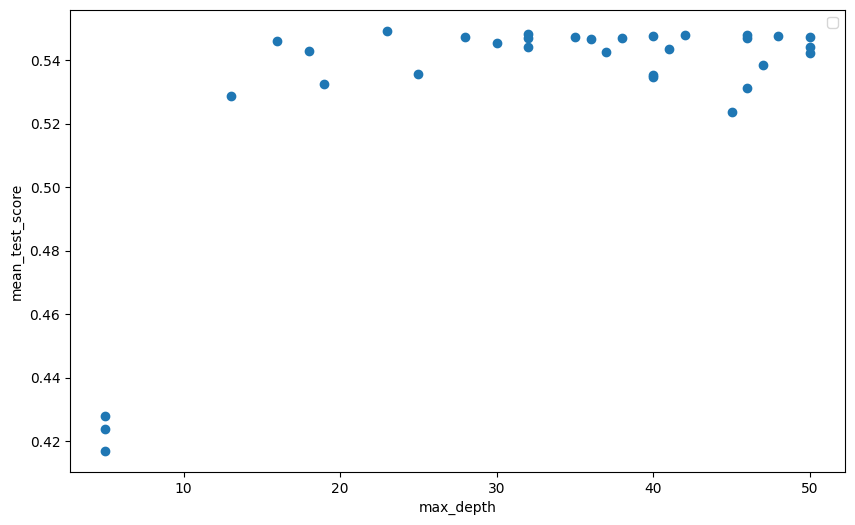

In [38]:
plot_search_results(bayes_search.cv_results_,'max_depth' )

In [39]:

rfc1=RandomForestClassifier(**bayes_search.best_params_)
start_time = time.time()
rfc1.fit(X_train, y_train)
print("The total time for training process is %.4f s."%(time.time()-start_time))
y_pred=rfc1.predict(X_test)
f1_score(y_test,y_pred,average='micro')


The total time for your training process is 29.4849 s.


0.5814031554212823

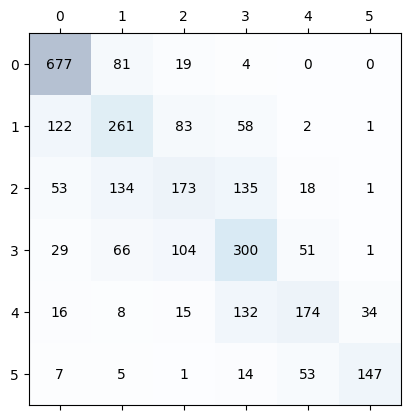

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

In [47]:
# Was planning to drop a few low importance features to improve performance, but it cannot
feature_importances = rfc1.feature_importances_
# Sort the features by their importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]
cumulative_importances = np.cumsum(sorted_importances)
# Find the features contributing to the first 80% of importance
index_of_80_percent = np.where(cumulative_importances >= 0.70)[0][0] + 1
top_features = sorted_features[:index_of_80_percent]
top_features

Index(['bathroom_number', 'accommodates', 'longitude', 'latitude',
       'neighbourhood_freq', 'amenities_count', 'beds', 'host_since',
       'property_freq', 'availability_365', 'host_total_listings_count',
       'number_of_reviews', 'calculated_host_listings_count_entire_homes',
       'host_listings_count', 'availability_90',
       'calculated_host_listings_count'],
      dtype='object')

In [48]:

# hyperparameters for Bayesian Optimization
XGB_param = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'min_child_weight': (1, 10),
    'max_depth': (3, 50),
    'max_delta_step': (0, 50),
    'subsample': (0.1, 1.0),
    'n_estimators': (50, 200),    
}
# Using Bayesian Optimization for hyperparameter tuning
xgb_clf = XGBClassifier(objective='multi:softprob', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bayes_search = BayesSearchCV(
    estimator=xgb_clf,
    search_spaces=XGB_param,
    scoring=make_scorer(f1_score,average='weighted'),
    cv=cv,
    n_iter=32,                
    n_jobs=-1,               
    return_train_score=True,
    random_state=42
)
bayes_search.fit(X_train, y_train)
bayes_search.best_params_





c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

OrderedDict([('learning_rate', 0.1143843944509733),
             ('max_delta_step', 49),
             ('max_depth', 10),
             ('min_child_weight', 1),
             ('n_estimators', 200),
             ('subsample', 0.8564281778776754)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


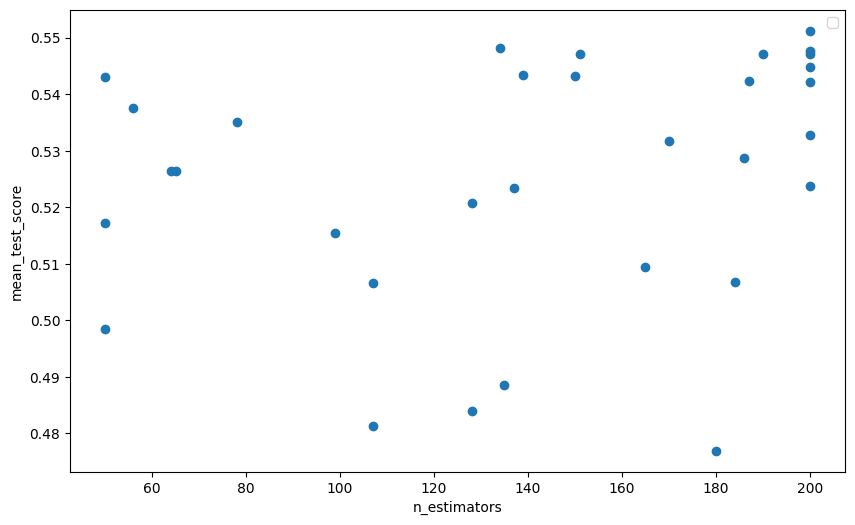

In [49]:
plot_search_results(bayes_search.cv_results_,'n_estimators' )

In [52]:
rfc1=XGBClassifier(bayes_search.best_params_,objective='multi:softprob', random_state=42)
start_time = time.time()
rfc1.fit(X_train, y_train)

print("The total time for training process is %.4f s."%(time.time()-start_time))

y_pred=rfc1.predict(X_test)
f1_score(y_test,y_pred,average='micro')

c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Us

The total time for training process is 0.5574 s.


c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

0.5615978516280631

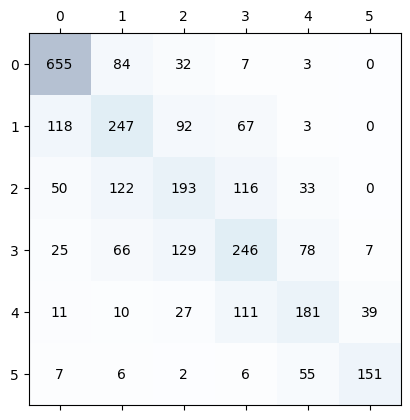

In [53]:
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')


In [ ]:
file_path = 'test.csv'
test_data = pd.read_csv(file_path)
cleaned_test_data = process(test_data,neighbourhood_freq,property_type_freq)

6291 6291


In [54]:
y_pred = rfc1.predict(cleaned_test_data)

submission = pd.DataFrame({
    'id': test_data['id'],
    'price': y_pred
})

submission.to_csv('submission.csv', index=False)

c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.